In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from IPython.display import display
%matplotlib inline
from sklearn import model_selection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

ptb_abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('ptbdb_normal.csv', header=None)

# Concatenation des deux DataFrames train & test 
ptb = pd.concat([ptb_normal, ptb_abnormal], ignore_index=True, sort=False)
ptb.rename(columns={187 :'class'}, inplace=True)

# Datasets MITBIH train & test  
mit_train = pd.read_csv('mitbih_train.csv', header=None)
mit_test = pd.read_csv('mitbih_test.csv', header=None)

# Concatenation des deux DataFrames train & test 
mit = pd.concat([mit_train, mit_test], ignore_index=True, sort=False)
mit.rename(columns={187 :'class'}, inplace=True)

mit['class'].replace({2:1,3:1,4:1}, inplace=True)
data = pd.concat([ptb, mit], ignore_index=True, sort=False)

y = data['class'].copy()
X = data.drop('class', axis=1).copy()

X_train90, X_valid, y_train90, y_valid = train_test_split(X, y, train_size=0.9, random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train90, y_train90, train_size=0.8, random_state=1,shuffle=True)

In [2]:
#itération standard
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.90     16935
         1.0       0.80      0.45      0.57      5385

    accuracy                           0.84     22320
   macro avg       0.83      0.71      0.74     22320
weighted avg       0.84      0.84      0.82     22320

[[16350   585]
 [ 2979  2406]]


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
#itération undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

lr = LogisticRegression()
lr.fit(X_ru, y_ru)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

Classes échantillon undersampled : {0.0: 21103, 1.0: 21103}
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84     16935
         1.0       0.52      0.68      0.59      5385

    accuracy                           0.77     22320
   macro avg       0.70      0.74      0.72     22320
weighted avg       0.80      0.77      0.78     22320



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
#recherche des meilleurs paramètres
clf_lr = LogisticRegression(max_iter=1000)
params_lr = {'solver': ['liblinear', 'lbfgs'], 'C': [10**(i) for i in range(-4, 4)]}
gridcv = GridSearchCV(clf_lr, param_grid=params_lr, scoring='accuracy', cv=5)  
gridcv.fit(X_ru, y_ru)

df = pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
df

,params,mean_test_score,std_test_score
0,"{'C': 0.0001, 'solver': 'liblinear'}",0.671492,0.004328
1,"{'C': 0.0001, 'solver': 'lbfgs'}",0.681443,0.003365
2,"{'C': 0.001, 'solver': 'liblinear'}",0.696702,0.002543
3,"{'C': 0.001, 'solver': 'lbfgs'}",0.692034,0.004812
4,"{'C': 0.01, 'solver': 'liblinear'}",0.715917,0.003913
5,"{'C': 0.01, 'solver': 'lbfgs'}",0.714827,0.004031
6,"{'C': 0.1, 'solver': 'liblinear'}",0.725300,0.004709
7,"{'C': 0.1, 'solver': 'lbfgs'}",0.725181,0.004699
8,"{'C': 1, 'solver': 'liblinear'}",0.733853,0.004294
9,"{'C': 1, 'solver': 'lbfgs'}",0.734019,0.004234


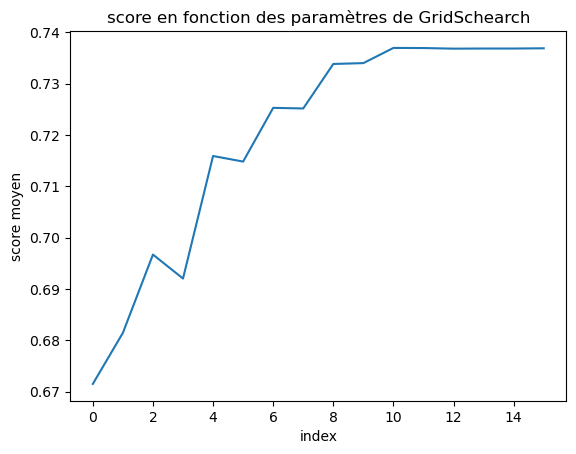

In [5]:
#plot
plt.plot(df.index, df['mean_test_score'])
plt.xlabel('index')
plt.ylabel('score moyen')
plt.title('score en fonction des paramètres de GridSchearch');

In [6]:
#itération undersampling + meilleurs paramètres
lr = LogisticRegression(C=1000, solver = 'liblinear', max_iter=1000)
lr.fit(X_ru, y_ru)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84     16935
         1.0       0.52      0.69      0.59      5385

    accuracy                           0.77     22320
   macro avg       0.71      0.74      0.72     22320
weighted avg       0.80      0.77      0.78     22320

[[13553  3382]
 [ 1692  3693]]


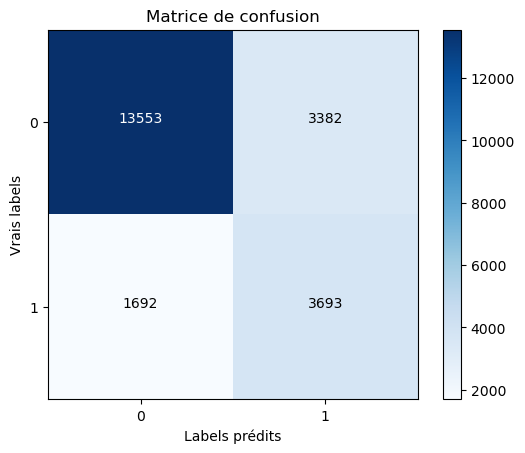

In [8]:
#matrice couleur
import itertools
import numpy as np
classes = range(0,2)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

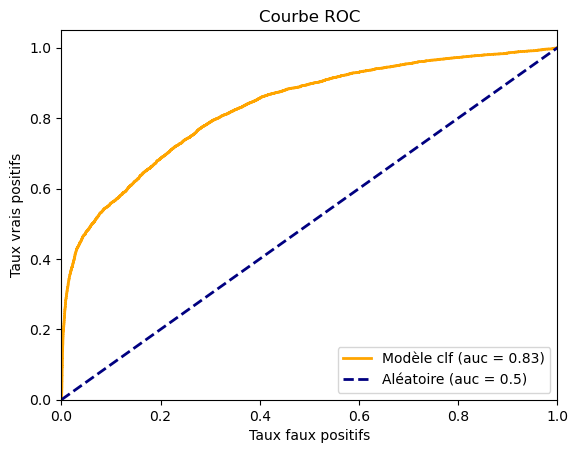

In [9]:
#courbe roc
probs = lr.predict_proba(X_test)

fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

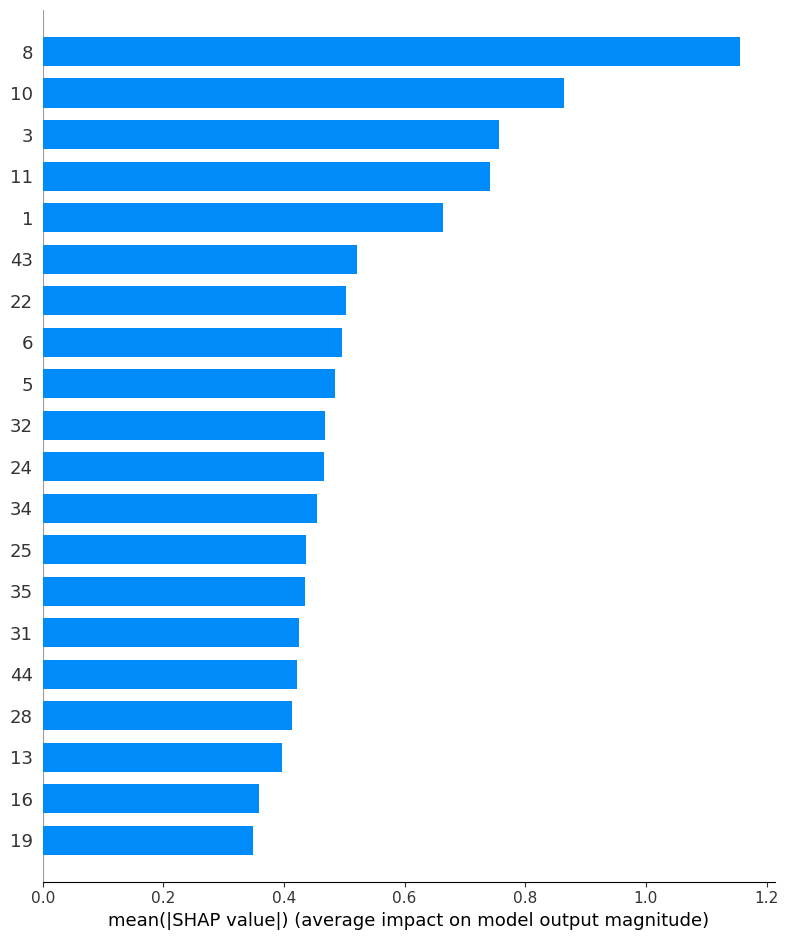

In [10]:
#interprétabilté: valeurs importantes

import shap

explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_valid, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


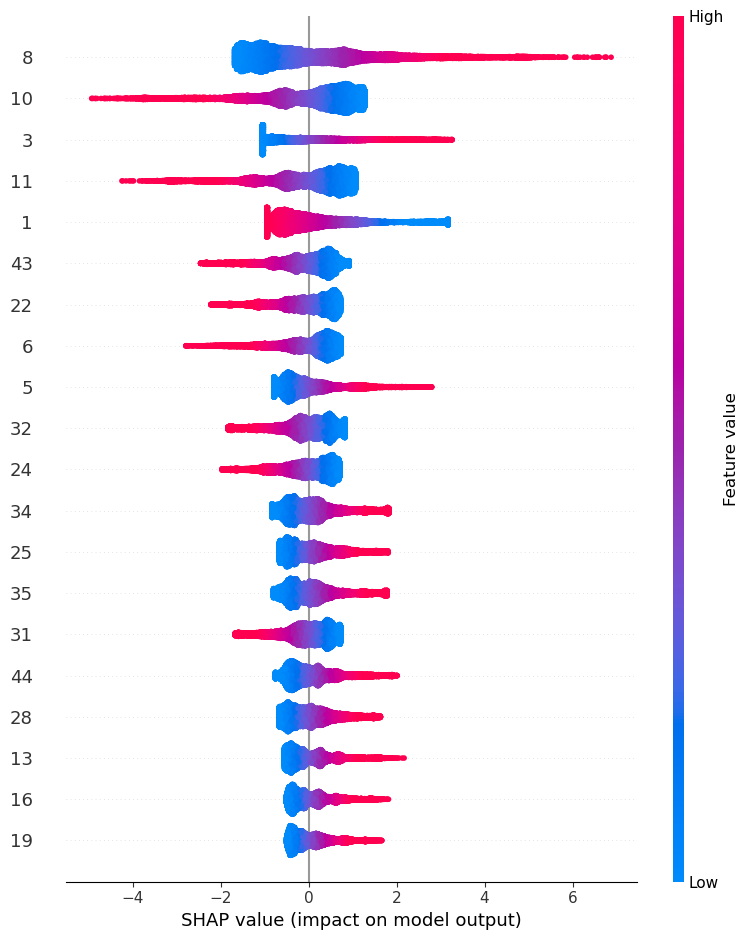

In [11]:
#interprétabilté: valeurs importantes 2 
shap.summary_plot(shap_values, X_test)

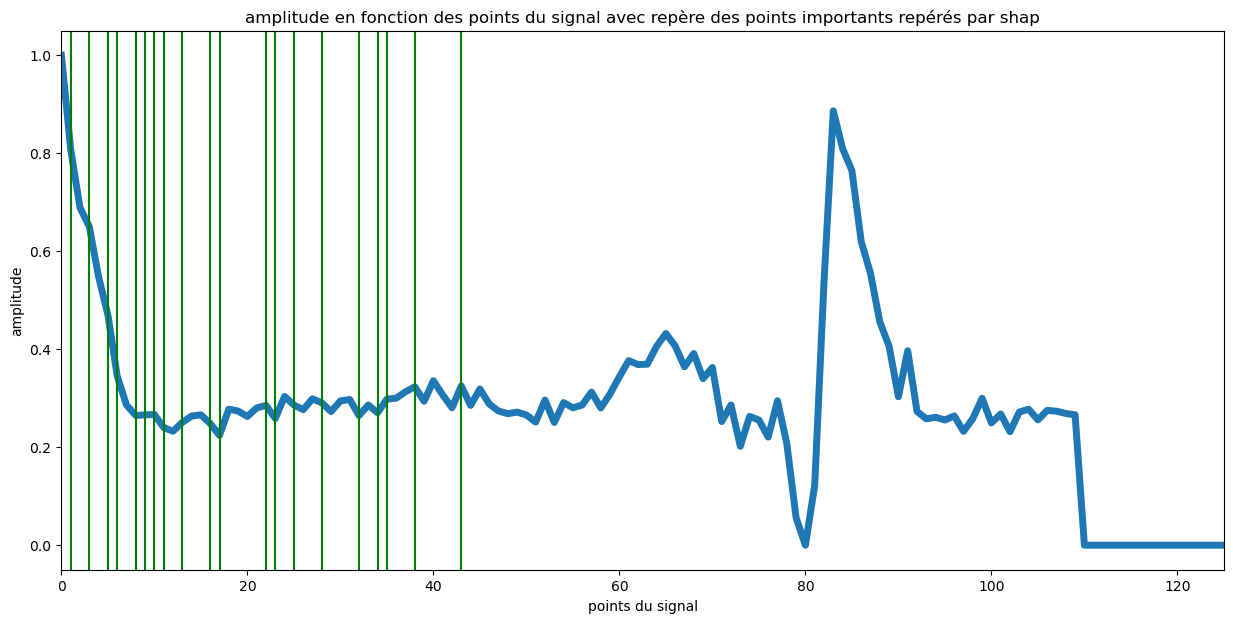

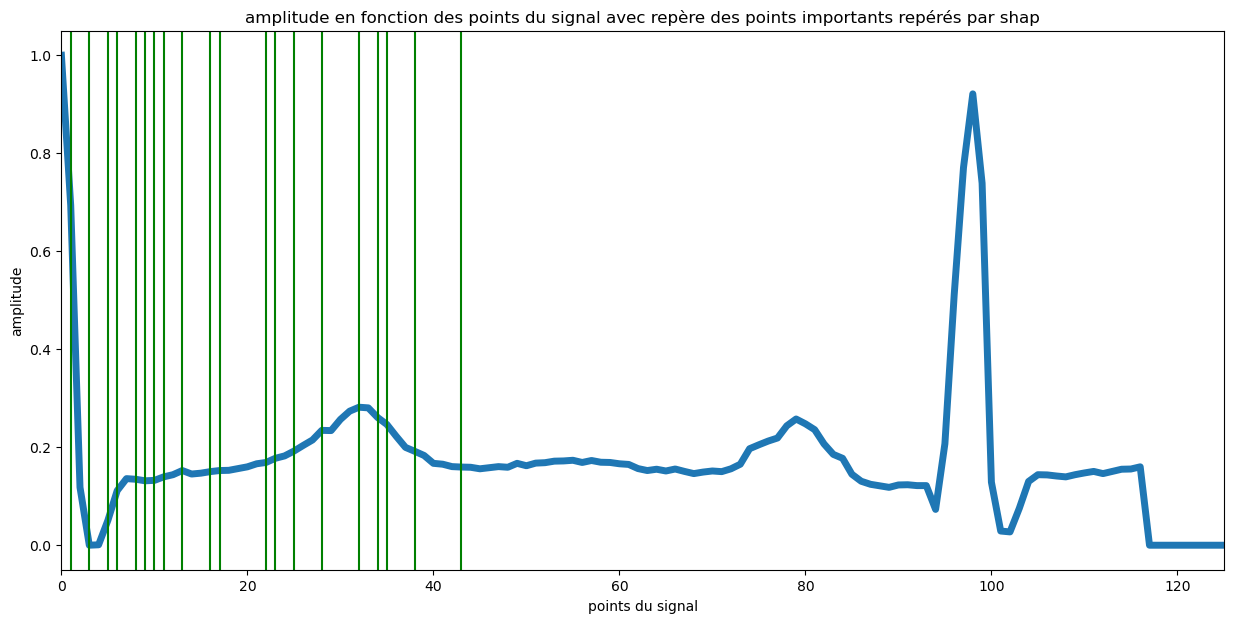

In [12]:
#interprétabilté: valeurs sur deux signaux choisis aléatoirement

pts = np.arange(187)

for i in [4444, 577]:
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,1,1)
    ax.plot(pts,data.values[i,:-1], linewidth=5)  #permet de selectionner un signal
    plt.xlabel("points du signal")
    plt.ylabel("amplitude")
    plt.title("amplitude en fonction des points du signal avec repère des points importants repérés par shap")
   
    for x in [8, 11, 10, 3, 13, 1, 34, 32, 23, 6, 5, 28, 22, 9, 25, 35, 43, 38, 17, 16]:
        plt.axvline(x,color="g", label = 'Régression Logistique') 
    plt.xlim(0, 125)
 
plt.show();